In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
# Generate moons dataset
X, y = make_moons(n_samples=100, noise=0.05, random_state=42)

In [3]:
# Visualize data
def visualize_moons(X, y, title=''):
    colors_dict = {0: 'b', 1: 'r'}

    for color in colors_dict.keys():
        idx = np.where(y == color)
        plt.scatter(X[idx, 0], X[idx, 1], c=colors_dict[color], label=color)
    
    plt.title(title)
    plt.legend()
    plt.show()

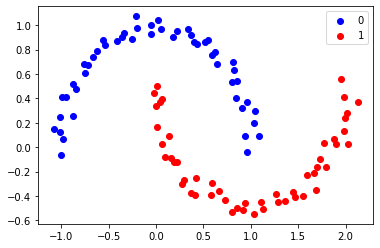

In [4]:
visualize_moons(X, y)

In [5]:
def generate_V_matrix(X):
    # max_dims are the upper bounds of each dimension.
    # Since there is not clear specification on which values have to be picked,
    # using the maximum for each dimension should be a good choice
    max_dims = np.max(X, axis=0)

    V = np.array([[np.prod(max_dims - np.maximum(x_i, x_j)) for x_j in X] for x_i in X])

    return V


def inference_algorithm(X, y, use_v_matrix=False, gamma=0.001, rbf_gamma=None):
    n = len(y)

    # Compute V matrix and Gramm matrix
    V = generate_V_matrix(X) if use_v_matrix else np.eye(n)
    K = rbf_kernel(X, gamma=rbf_gamma)

    # Helpers
    ones_vector = np.ones(n)
    perturbation = np.diagflat(gamma * ones_vector)

    VK_prod = np.dot(V, K)
    perturbed_VK_inv = np.linalg.inv(VK_prod + perturbation)

    # Compute A_b and A_c, which will be used to compute c
    A_b = np.dot(perturbed_VK_inv, np.dot(V, y))
    A_c = np.dot(perturbed_VK_inv, np.dot(V, ones_vector))

    numerator = np.dot(ones_vector, np.dot(VK_prod, A_b)) - np.dot(ones_vector, np.dot(V, y))
    denominator = np.dot(ones_vector, np.dot(VK_prod, A_c)) - np.dot(ones_vector, np.dot(V, ones_vector))

    # Compute closed-form solution of the minimization problem
    c = numerator / denominator
    A = A_b - c * A_c

    return A, c


def predict(X, A, c, gamma=None):
    # Apply decision rule
    decision = np.dot(A, rbf_kernel(X, X, gamma=gamma)) + c

    # Get label: if the result of the decision rule is smaller than 0.5, then
    # it's classified as 0. Otherwise, it's classified as 1
    prediction = np.where(decision < 0.5, 0, 1).flatten()

    return prediction

In [6]:
# Run normal inference
A, c = inference_algorithm(X, y)
y_predict = predict(X, A, c)

In [7]:
def visualize_decision_boundary(X, A, gamma=None):
    xx,yy = np.meshgrid(np.linspace(-2,3,200),np.linspace(-2,3,200))
    viz=np.c_[xx.ravel(),yy.ravel()]

    z = np.dot(A, rbf_kernel(X, viz, gamma=gamma)) + c

    plt.scatter(X[:, 0], X[:, 1], c=y,   alpha=0.7)
    plt.gca().set_xlim([-2.,3.])
    plt.gca().set_ylim([-2.,3.])
    plt.imshow(z.reshape((200,200)), interpolation='bilinear', origin='lower', extent=(-2,3,-2,3),alpha=0.3, vmin=0, vmax=1)
    plt.contour(xx,yy,z.reshape((200,200)))

    plt.gcf().set_size_inches((9,9))

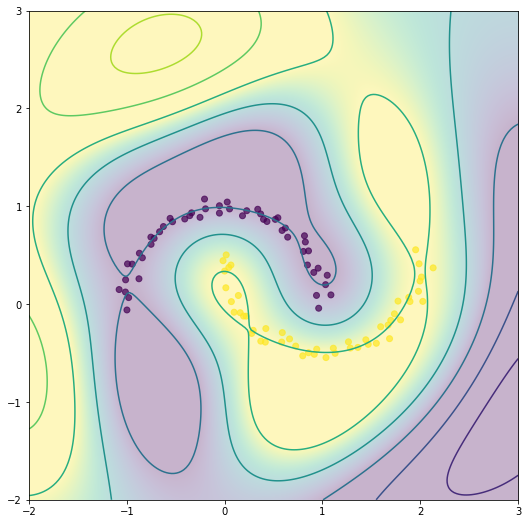

In [8]:
visualize_decision_boundary(X, A)

In [9]:
A_vmat, c_vmat = inference_algorithm(X, y, use_v_matrix=True)
y_predict_vmat = predict(X, A_vmat, c_vmat)

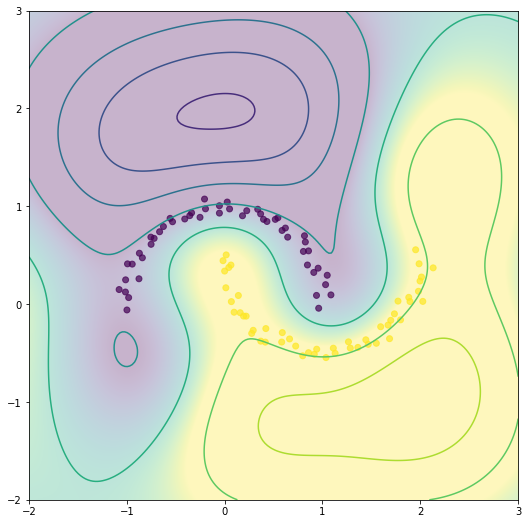

In [10]:
visualize_decision_boundary(X, A_vmat)